Epoch 1/150
7/7 [==============================] - 0s 28ms/step - loss: 2.7997 - accuracy: 0.0622 - val_loss: 2.7026 - val_accuracy: 0.0571
Epoch 2/150
7/7 [==============================] - 0s 17ms/step - loss: 2.7702 - accuracy: 0.0718 - val_loss: 2.6509 - val_accuracy: 0.1857
Epoch 3/150
7/7 [==============================] - 0s 16ms/step - loss: 2.6763 - accuracy: 0.0861 - val_loss: 2.6173 - val_accuracy: 0.1857
Epoch 4/150
7/7 [==============================] - 0s 16ms/step - loss: 2.6210 - accuracy: 0.1292 - val_loss: 2.5829 - val_accuracy: 0.1857
Epoch 5/150
7/7 [==============================] - 0s 17ms/step - loss: 2.5779 - accuracy: 0.1388 - val_loss: 2.5542 - val_accuracy: 0.1857
Epoch 6/150
7/7 [==============================] - 0s 20ms/step - loss: 2.5476 - accuracy: 0.1340 - val_loss: 2.5262 - val_accuracy: 0.1857
Epoch 7/150
7/7 [==============================] - 0s 20ms/step - loss: 2.5245 - accuracy: 0.1292 - val_loss: 2.5005 - val_accuracy: 0.1857
Epoch 8/150
7/7 [===

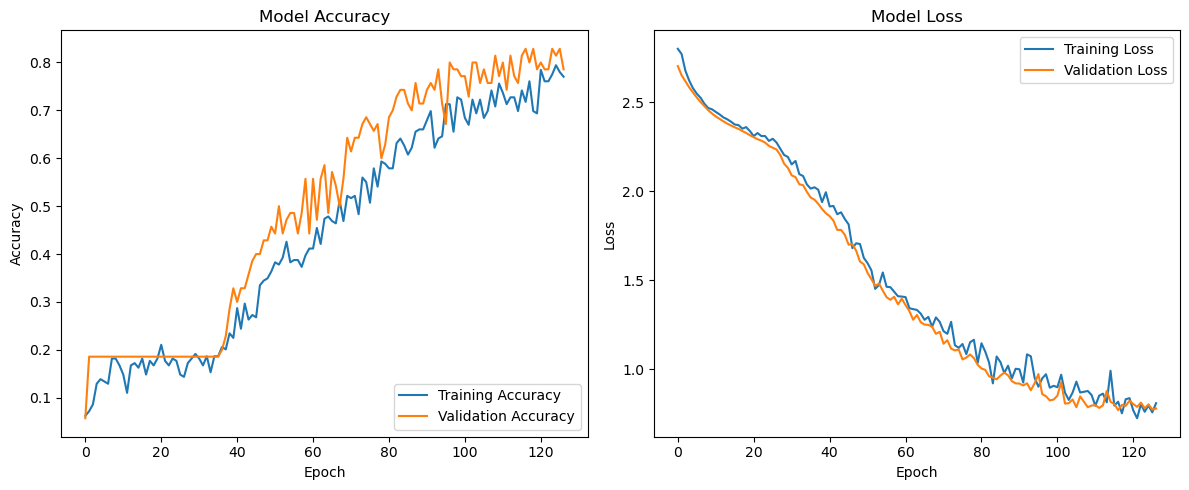

In [34]:
import random
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

# Set the random seed for reproducibility
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load augmented_intents.json
with open('augmented_intents.json') as file:
    intents = json.load(file)

# Extract patterns and labels from intents
patterns = [pattern for intent in intents['intents'] for pattern in intent['patterns']]
labels = [intent['tag'] for intent in intents['intents'] for _ in intent['patterns']]

# Tokenize and pad the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(patterns)
sequences = tokenizer.texts_to_sequences(patterns)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# Pad sequences to the same length
max_len = 250
data = pad_sequences(sequences, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(data, labels_one_hot, test_size=0.2, random_state=5)

# Further split the training data into training and validation sets
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=5)

# Create the model
model = Sequential()
model.add(Embedding(vocab_size, 120, input_length=max_len))
model.add(Dropout(0.5))
model.add(Flatten())  # Flatten the 3D tensor to 2D tensor for Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.35))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(labels_one_hot.shape[1], activation='softmax'))  # Adjust the output layer to match the number of classes

# Compile the model
optimizer = Adam(learning_rate=0.001, weight_decay = 0.001)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(train_x, 
                    train_y, 
                    epochs=150, 
                    batch_size=32,
                    verbose=1,
                    validation_data=(valid_x, valid_y), 
                    callbacks=[early_stopping],
                    shuffle=False
                    )

'''Training the model and save it'''
# model.save("chatbot_seq_emb.h5")

# Evaluate the model
train_loss, train_accuracy = model.evaluate(train_x, train_y)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

test_loss, test_accuracy = model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()